In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import biogeme.vns as vns
import biogeme.database as db

# Pareto reader

This notebook is used to display the information contained in the Pareto set generated by the algorithm, and saved in the pickle file. 

We need the following just to know the sample size. 

In [2]:
df = pd.read_csv('optima.dat', '\t')

database = db.Database('optima', df)

globals().update(database.variables)

exclude = ((Choice == -1) + (CostCarCHF < 0)) > 0
database.remove(exclude)

sampleSize = database.getSampleSize()
sampleSize

/Users/michelbierlaire/opt/anaconda3/envs/python39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


1906

The information about the approximation of the Pareto set is saved regularly by the algorithm in a pickle file. We first open it. 

In [3]:
pickleFile = 'optimaPareto.pickle'

In [4]:
pareto = vns.paretoClass(20, archiveInputFile=pickleFile)

In [5]:
print(f'Number of pareto solutions: {len(pareto.pareto)}')

Number of pareto solutions: 9


We calculate the AIC and the BIC for each non dominated  model.

In [6]:
def AIC(k, LL):
    """Calculate the Aikaike Information Criterion for a model with k parameters and final log liklelihood LL"""
    return 2 * k - 2 * LL

In [7]:
def BIC(k, LL):
    """Calculate the Bayesian Information Criterion for a model with k parameters and final log liklelihood LL"""
    return k * np.log(sampleSize) - 2 * LL


## List of Pareto solutions: performance measures

In [8]:
bestBIC = None
bestAIC = None
summary = []
besti = -1
bestj = -1
for p in pareto.pareto:
    res = ''
    for t, r in zip(p.objectivesNames, p.objectives):
        res += f'{t}: {r}\t'
    L = p.objectives[0]
    k = p.objectives[1]
    A = AIC(k, -L)
    B = BIC(k, -L)
    res += f'BIC = {B:.3f}\tAIC = {A:.3f}'
    summary.append(res)
    if bestBIC is None or B < bestBIC:
        bestBIC = B
        besti = len(summary) - 1
    if bestAIC is None or A < bestAIC:
        bestAIC = A
        bestj = len(summary) - 1
for i in range(len(summary)):
    if i == besti:
        if i == bestj:
            pre = f'{i+1:3} **'
        else:
            pre = f'{i+1:3} B*'
    elif i == bestj:
        pre = f'{i+1:3} A*'
    else:
        pre = f'{i+1:3}   '
    print(f'{pre} {summary[i]}')

  1    Neg. log likelihood: 1270.8917183562135	#parameters: 4	BIC = 2571.994	AIC = 2549.783
  2    Neg. log likelihood: 1270.8917183562135	#parameters: 4	BIC = 2571.994	AIC = 2549.783
  3 ** Neg. log likelihood: 1048.8720199241684	#parameters: 10	BIC = 2173.272	AIC = 2117.744
  4    Neg. log likelihood: 1127.5219885460538	#parameters: 6	BIC = 2300.361	AIC = 2267.044
  5    Neg. log likelihood: 1048.6155077520634	#parameters: 11	BIC = 2180.311	AIC = 2119.231
  6    Neg. log likelihood: 1066.0808640553062	#parameters: 8	BIC = 2192.584	AIC = 2148.162
  7    Neg. log likelihood: 1060.649829539309	#parameters: 9	BIC = 2189.275	AIC = 2139.300
  8    Neg. log likelihood: 1150.6195082488612	#parameters: 5	BIC = 2339.003	AIC = 2311.239
  9    Neg. log likelihood: 1088.4555762291939	#parameters: 7	BIC = 2229.780	AIC = 2190.911


## List of Pareto solutions: model specifications

In [9]:
counter = 0 
for p in pareto.pareto:
    counter += 1
    print(f'*************** Model {counter} ************************')
    print(p)
    print('\n')
    

*************** Model 1 ************************
Logit-------------------
Alternative pt [0]
-------------------
Cte. 
PT travel time [generic] 



--------------------
Alternative car [1]
--------------------
Cte. 
Car travel time [generic] 

-------------------
Alternative sm [2]
-------------------
Distance [alt. spec.] 

Neg. log likelihood: 1270.8917183562135
#parameters: 4


*************** Model 2 ************************
Nested 2-------------------
Alternative pt [0]
-------------------
Cte. 
PT travel time [generic] 



--------------------
Alternative car [1]
--------------------
Cte. 
Car travel time [generic] 

-------------------
Alternative sm [2]
-------------------
Distance [alt. spec.] 

Neg. log likelihood: 1270.8917183562135
#parameters: 4


*************** Model 3 ************************
Cross nested 2-------------------
Alternative pt [0]
-------------------
Cte. 
PT travel time [alt. spec.] 
PT travel cost [generic] <Subscription>


--------------------
Alternati

## List of Pareto solutions: illustration

The plot below illustrates all models considered by the algorithm. Each model corresponds to one point in the graph. 

- The x-coordinate corresponds to the negative log likelihood of the model, and the y-coordinate to the number of parameters. 
- The larger circles correspond to all models that are not dominated. 
- The crosses corresponds to model that happened to be non dominated at some point during the course of the algorithm, but have been removed from the Pareto set afterwards, as a dominating model has been identified.
- Finally, the small dots corresponds to models that have been considered, but rejected because dominated by another model already in the set. 

In [10]:
objectives = list(pareto.pareto)[0].objectivesNames
objectives

['Neg. log likelihood', '#parameters']

In [11]:
par_obj = [p.objectives for p in pareto.pareto]
par_x, par_y = zip(*par_obj)

In [12]:
con_obj = [p.objectives for p in pareto.considered]
con_x, con_y = zip(*con_obj)

In [13]:
rem_obj = [p.objectives for p in pareto.removed]
rem_x, rem_y = zip(*rem_obj)

In [14]:
x_buffer = 10
y_buffer = 0.1

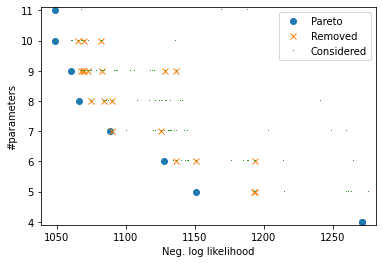

In [15]:
plt.axis([min(par_x)-x_buffer,
          max(par_x)+x_buffer,
          min(par_y)-y_buffer,
          max(par_y)+y_buffer])
plt.plot(par_x, par_y, 'o', label='Pareto')
plt.plot(rem_x, rem_y, 'x', label='Removed')
plt.plot(con_x, con_y, ',', label='Considered')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])
plt.legend()